In [1]:
import numpy as np
import scipy.stats as sps
from array import array
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [4]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

# Load data

In [5]:
dataDir = '../data/cmsMC_private/'
datasets_loc = []

datasets_loc += glob(dataDir + 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_muonIPstudy/*.root')

In [16]:
tree = rt.TChain('outA/Tevts')

for floc in datasets_loc:
    tree.Add(floc)
#     if tree.GetEntries()>100000:
#         break

print 'N evts: {:.0f}'.format(tree.GetEntries())

N evts: 1859223


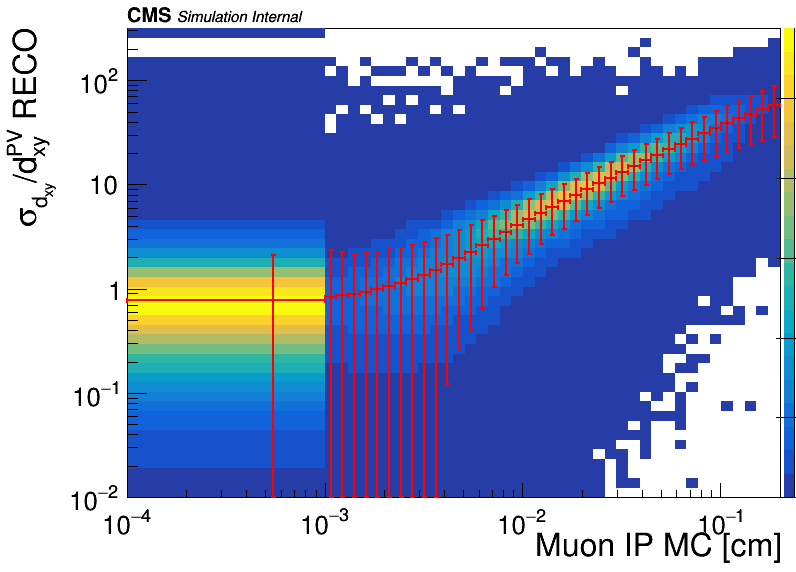

In [17]:
binx = array('d', [1e-4] + list(np.logspace(-3, -0.7, 40)))
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['Muon IP MC [cm]', '#sigma_{d_{xy}}/d_{xy}^{PV} RECO', 'Events'],
                binning=[binx, np.logspace(-2, 2.5, 50)]
               )
tree.Project('h', 'recoMu_sigdxy:mcMu_IP', '')

h_p = h.ProfileX('p_pfx', 1, -1, 's')
h_p.SetLineColor(2)

c = drawOnCMSCanvas(CMS_lumi, [h, h_p], ['colz', 'sameE1'])
c.SetLogx()
c.SetLogy()
c.Draw()

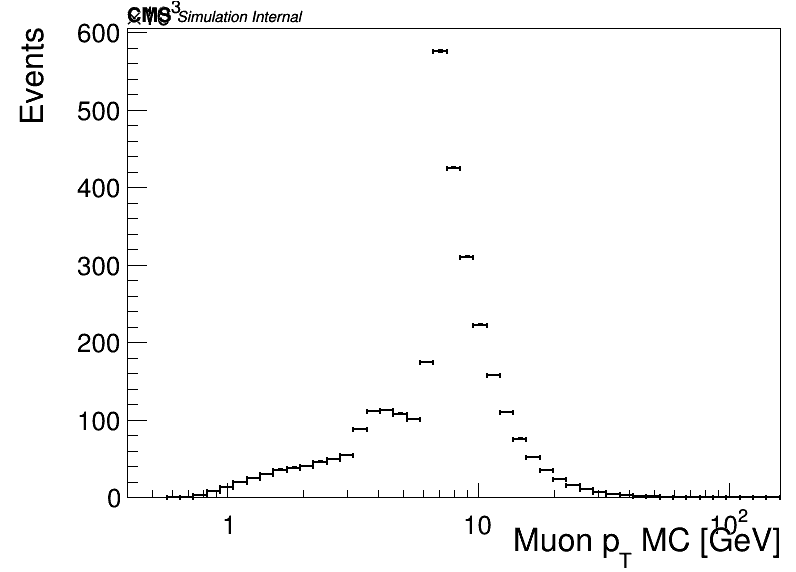

In [18]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Muon p_{T} MC [GeV]', 'Events'],
                binning=np.logspace(-0.4, 2.2, 50)
               )
tree.Project('h', 'mcMu_pt', '')

c = drawOnCMSCanvas(CMS_lumi, [h], ['E1'])
c.SetLogx()
c.Draw()

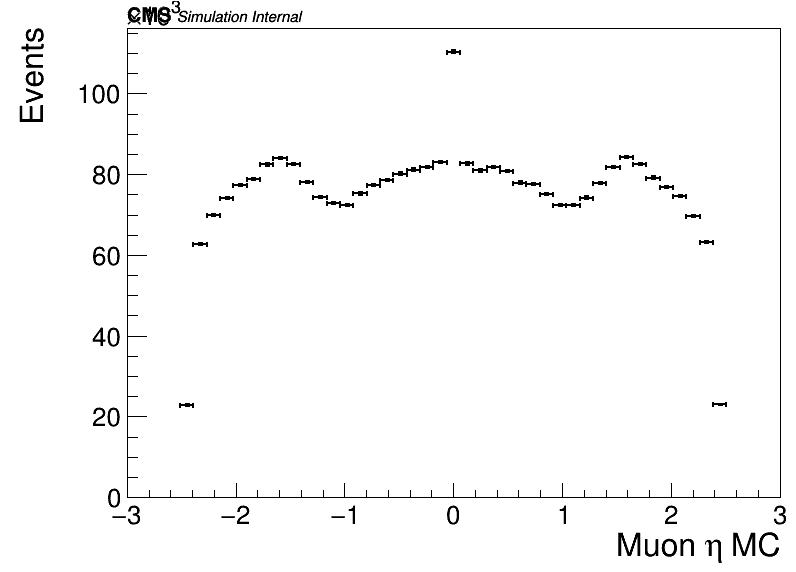

In [19]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Muon #eta MC', 'Events'],
                binning=np.linspace(-3, 3, 50)
               )
tree.Project('h', 'mcMu_eta', 'mcMu_eta!=0')

c = drawOnCMSCanvas(CMS_lumi, [h], ['E1'])
c.Draw()

0 0
859
0 1
860
0 2
861
1 0
631
1 1
632
1 2
633
2 0
415
2 1
416
2 2
417


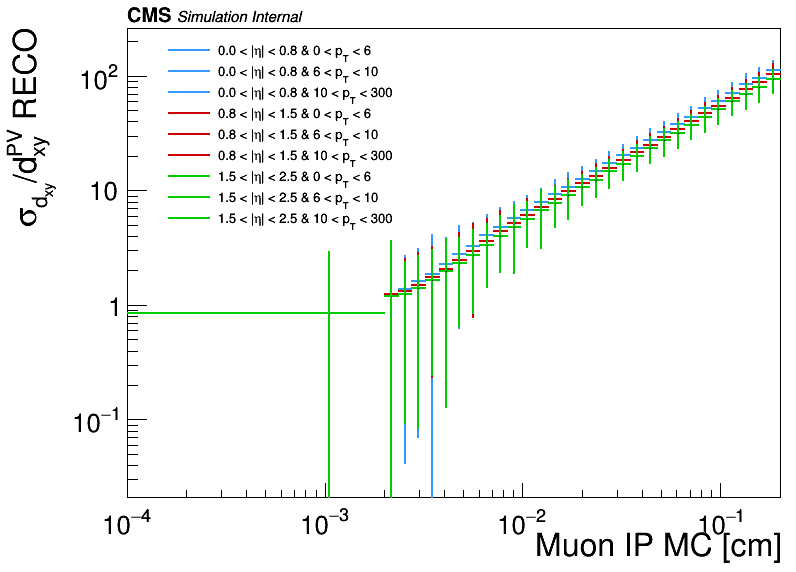

In [31]:
h_l = []
eta_bin = [0, 0.8, 1.5, 2.5]
pt_bin = [0, 6, 10, 300]
colors = [rt.kAzure, rt.kRed, rt.kGreen]

leg = rt.TLegend(0.2, 0.6, 0.5, 0.93)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

fout = open('../data/calibration/sigdxyRECO_vs_ipMC.txt', 'w')
fout.write('#'+'\t'.join(['etamin', 'etamax', 'ptmin', 'ptmax','ipMC','mean', 'sigma'])+'\n')
for ie in range(len(eta_bin)-1):
    eta_cut = 'fabs(mcMu_eta) > {} && fabs(mcMu_eta) < {}'.format(eta_bin[ie], eta_bin[ie+1])
    for ip in range(len(pt_bin)-1):
        print ie, ip
        pt_cut = 'mcMu_pt > {} && mcMu_pt < {}'.format(pt_bin[ip], pt_bin[ip+1])
    
        binx = array('d', [1e-4] + list(np.logspace(-2.7, -0.7, 30)))
        h = create_TH2D(np.zeros((2,2)), name='h',
                        title='',
                        axis_title=['Muon IP MC [cm]', '#sigma_{d_{xy}}/d_{xy}^{PV} RECO', 'Events'],
                        binning=[binx, np.logspace(-2, 2.5, 50)]
                       )
        tree.Project('h', 'recoMu_sigdxy:mcMu_IP', eta_cut + ' && ' + pt_cut)

        h_p = h.ProfileX('p_pfx_'+str(ie), 1, -1, 's')
        print(colors[ie]+ip-1)
        h_p.SetLineColor(colors[ie]+ip-1)
        for i in range(1, len(binx)):
            l = [eta_bin[ie], eta_bin[ie+1], pt_bin[ip], pt_bin[ip+1]]
            l += [h_p.GetBinCenter(i), h_p.GetBinContent(i), h_p.GetBinError(i)]
            s = '{:.1f},{:.1f},{:.0f},{:.0f},{:1.2e},{:.1f},{:.1f}\n'.format(*l)
            fout.write(s)
            
        h_p.GetYaxis().SetTitle('#sigma_{d_{xy}}/d_{xy}^{PV} RECO')

        eta_str = '{:.1f} < |#eta| < {:.1f}'.format(eta_bin[ie], eta_bin[ie+1])
        pt_str = '{:.0f} < p_{{T}} < {:.0f}'.format(pt_bin[ip], pt_bin[ip+1])
        leg.AddEntry(h_p, eta_str + ' & ' + pt_str, 'l')

        h_l.append(h_p)

c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')
leg.Draw()
c.SetLogx()
c.SetLogy()
c.Draw()

In [30]:
!cat ../data/calibration/sigdxyRECO_vs_ipMC.txt

#etamin	etamax	ptmin	ptmax	ipMC	mean	sigma
0.0,0.8,0,6,1.05e-03,0.9,1.6
0.0,0.8,0,6,2.17e-03,1.1,3.1
0.0,0.8,0,6,2.54e-03,1.1,1.3
0.0,0.8,0,6,2.98e-03,1.2,1.2
0.0,0.8,0,6,3.49e-03,1.4,1.4
0.0,0.8,0,6,4.09e-03,1.5,1.5
0.0,0.8,0,6,4.79e-03,1.7,1.8
0.0,0.8,0,6,5.62e-03,2.0,1.9
0.0,0.8,0,6,6.59e-03,2.4,1.6
0.0,0.8,0,6,7.72e-03,2.8,1.6
0.0,0.8,0,6,9.05e-03,3.4,1.9
0.0,0.8,0,6,1.06e-02,4.0,2.5
0.0,0.8,0,6,1.24e-02,4.7,1.8
0.0,0.8,0,6,1.46e-02,5.6,2.0
0.0,0.8,0,6,1.71e-02,6.5,2.2
0.0,0.8,0,6,2.00e-02,7.7,2.8
0.0,0.8,0,6,2.35e-02,8.9,2.9
0.0,0.8,0,6,2.75e-02,10.4,3.0
0.0,0.8,0,6,3.22e-02,12.3,3.5
0.0,0.8,0,6,3.78e-02,14.4,4.0
0.0,0.8,0,6,4.43e-02,16.9,4.5
0.0,0.8,0,6,5.19e-02,19.5,5.1
0.0,0.8,0,6,6.08e-02,23.0,6.0
0.0,0.8,0,6,7.13e-02,26.9,7.1
0.0,0.8,0,6,8.36e-02,31.3,8.2
0.0,0.8,0,6,9.80e-02,37.0,9.4
0.0,0.8,0,6,1.15e-01,43.1,10.9
0.0,0.8,0,6,1.35e-01,50.6,12.9
0.0,0.8,0,6,1.58e-01,58.1,14.7
0.0,0.8,0,6,1.85e-01,69.5,17.4
0.0,0.8,6,10,1.05e-03,0.8,1.2
0.0,0.8,6,10,2.17e-03,1.1,1.0
0.0,0.8,6,